In [1]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt

from params import params, equations
import model

In [2]:
Net = Network()
neurons, states, spikes = model.make_neurons(Net, equations, params)
synapses = model.make_column_synapses(Net, neurons, params)
synapses.update(model.make_lateral_synapses(Net, neurons, params))
Net.store()

In [3]:
stream_indices = [1, 3]
occurrences = np.asarray([90, 5, 5])*5
n_trials = sum(occurrences)
print(f'n_trials = {n_trials}')

runtime = sum(params['stim_timing'])*params['stim_dt'] * n_trials
Pred = TimedArray(np.tile([1]*params['stim_timing'][0] + [0]*params['stim_timing'][1], n_trials) * params['input_strength'], dt=params['stim_dt'])

seq, stim_inputs = model.get_oddball_inputs(occurrences, stream_indices, params)
Stim = TimedArray(stim_inputs * params['input_strength'], dt=params['stim_dt'])

n_trials = 500


In [4]:
Net.restore()
Net.run(runtime)

In [5]:
raster_offset = 0.4
cmap = plt.cm.viridis_r
stim_labels = 'ABO'
seq_dt = params['stim_dt'] * sum(params['stim_timing'])

In [6]:
def plot_stim_raster(ax, seq, dt=seq_dt):
    for i in range(len(stim_labels)):
        ax.vlines(np.nonzero(seq==i) * dt, i-raster_offset, i+raster_offset, colors='k', lw=1)
    ax.set_yticks(*zip(*enumerate(stim_labels)))
    ax.invert_yaxis()

In [7]:
def plot_raster(ax, spike_monitor, indices=np.arange(params['N_streams'])):
    for i in range(params['N_streams']):
        mask = spike_monitor.i == indices[i]
        ax.vlines(spike_monitor.t[mask], i-raster_offset, i+raster_offset, colors=cmap(i/(params['N_streams']-1)), lw=1)
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

In [8]:
def plot_trace(ax, monitor, variable, indices=np.arange(params['N_streams']), div=mV):
    for i in range(params['N_streams']):
        ax.plot(monitor.t, getattr(monitor, variable)[indices[i]]/div, color=cmap(i/(params['N_streams']-1)))

Text(0.5, 0, 'Time (s)')

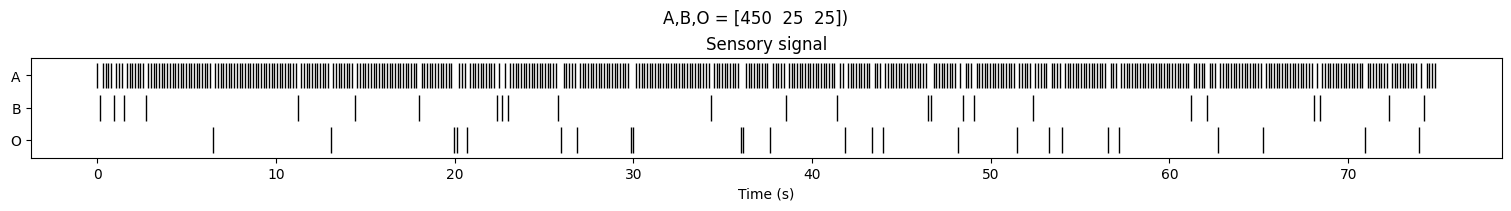

In [9]:
fig, ax = plt.subplots(figsize=(15,2), layout='constrained')
plt.suptitle(f'A,B,O = {occurrences})')
plt.title('Sensory signal')
plot_stim_raster(ax, seq)
plt.xlabel('Time (s)')

Text(0.5, 0, 'Time (s)')

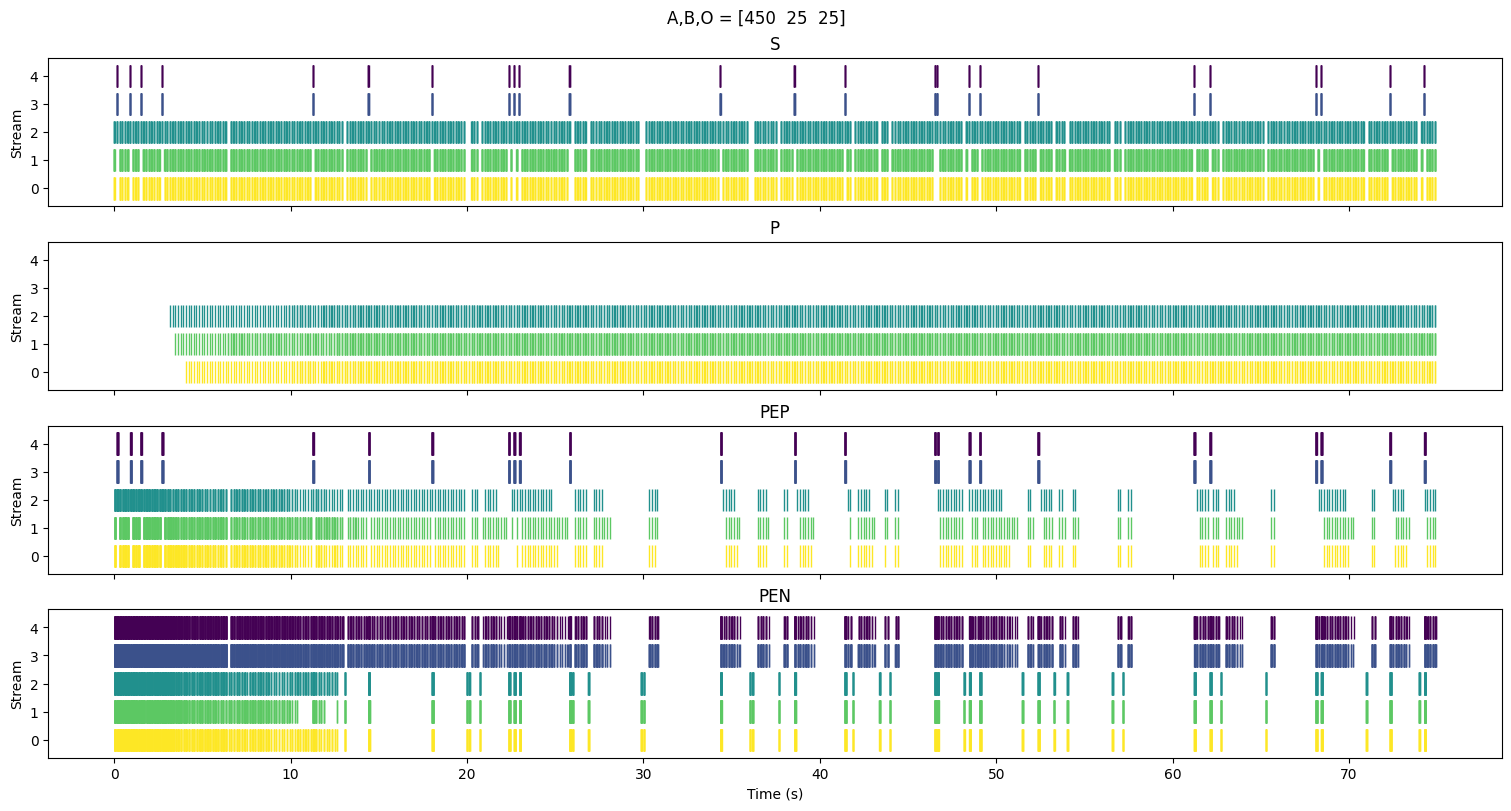

In [10]:
fig, axs = plt.subplots(4, figsize=(15,8), sharex=True, sharey=True, layout='constrained')
plt.suptitle(f'A,B,O = {occurrences}')

plot_raster(axs[0], spikes['S'])
axs[0].set_title('S')

plot_raster(axs[1], spikes['P'])
axs[1].set_title('P')

for group, ax in zip(['PEP', 'PEN'], axs[2:]):
    plot_raster(ax, spikes['circuit'], neurons[group].indices[:])
    ax.set_title(group)

for ax in axs:
    ax.set_ylabel('Stream')

axs[-1].set_xlabel('Time (s)')

Text(0.5, 0, 'Time (s)')

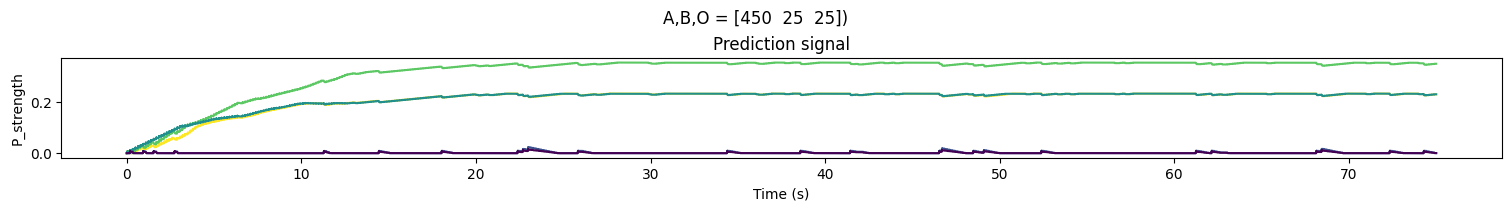

In [11]:
fig, ax = plt.subplots(figsize=(15,2), layout='constrained')
plt.suptitle(f'A,B,O = {occurrences})')
plt.title('Prediction signal')
plot_trace(ax, states['P'], 'w_pred', div=1)
plt.ylabel('P_strength')
plt.xlabel('Time (s)')

In [12]:
stim_colors = 'rbk'
stim_styles = ['-', '-', '--']

In [13]:
def chunk_spike_train(spike_train, seq, dt=seq_dt, before=seq_dt, after=2*seq_dt):
    trains = {i: {} for i in np.unique(seq)}
    for trial, trial_stim in enumerate(seq):
        t0 = trial*dt
        mask = (spike_train > t0 - before) & (spike_train < t0 + after)
        trains[trial_stim][trial] = spike_train[mask] - t0
    return dict(trains=trains, dt=dt, before=before, after=after)

In [14]:
def plot_trial_raster(axs, chunked_train):
    for i, trains in chunked_train['trains'].items():
        ax = axs[i]
        for trial, train in trains.items():
            ax.vlines(train, trial-.5, trial+.5, colors='k')
        ax.axvline(0, color=stim_colors[i], ls=stim_styles[i], lw=1)
        ax.axvline(chunked_train['dt']/second, color='k', lw=1)
        ax.set_xlim(-chunked_train['before'], chunked_train['after'])
        ax.set_ylabel('Trial')

In [15]:
def plot_rates(ax, chunked_train, bins=150, ignore_first_trials=0):
    for i, trains in chunked_train['trains'].items():
        spikes = [v for t,v in trains.items() if t >= ignore_first_trials]
        counts, edges = np.histogram(np.concatenate(spikes), range=(-chunked_train['before']/second, chunked_train['after']/second), bins=bins)
        rates = counts / (edges[1]-edges[0]) / len(spikes)
        ax.plot(edges[:-1] + np.diff(edges)/2, rates, label=stim_labels[i], c=stim_colors[i], ls=stim_styles[i])
    for x in (0, chunked_train['dt']/second):
        ax.axvline(x, color='k', lw=1)
    ax.set_xlim(-chunked_train['before']/second, chunked_train['after']/second)
    ax.legend()
    ax.set_ylabel('Spike rate ($s^{-1}$)')
    ax.set_xlabel('Time ($s$)')

In [16]:
trains = chunk_spike_train(spikes['circuit'].spike_trains()[neurons['PEN'].indices[1]], seq)

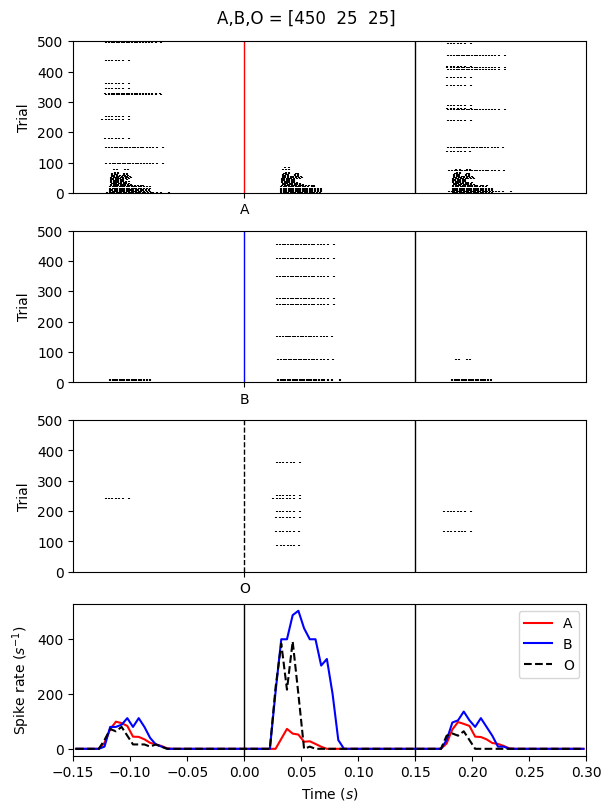

In [20]:
fig, axs = plt.subplots(4, figsize=(6,8), layout='constrained')
plt.suptitle(f'A,B,O = {occurrences}')
plot_trial_raster(axs, trains)

for label, ax in zip('ABO', axs):
    ax.set_xticks([0], [label])
    ax.set_ylim(0, n_trials)

plot_rates(axs[-1], trains, bins=90)

In [59]:
occurrences = np.asarray([5, 90, 5])*5
n_trials = sum(occurrences)

runtime = sum(params['stim_timing'])*params['stim_dt'] * n_trials
Pred = TimedArray(np.tile([1]*params['stim_timing'][0] + [0]*params['stim_timing'][1], n_trials) * params['input_strength'], dt=params['stim_dt'])

seq, stim_inputs = model.get_oddball_inputs(occurrences, stream_indices, params)
Stim = TimedArray(stim_inputs * params['input_strength'], dt=params['stim_dt'])

In [60]:
Net.restore()
Net.run(runtime)

In [61]:
trains = chunk_spike_train(spikes['circuit'].spike_trains()[neurons['PEN'].indices[1]], seq)

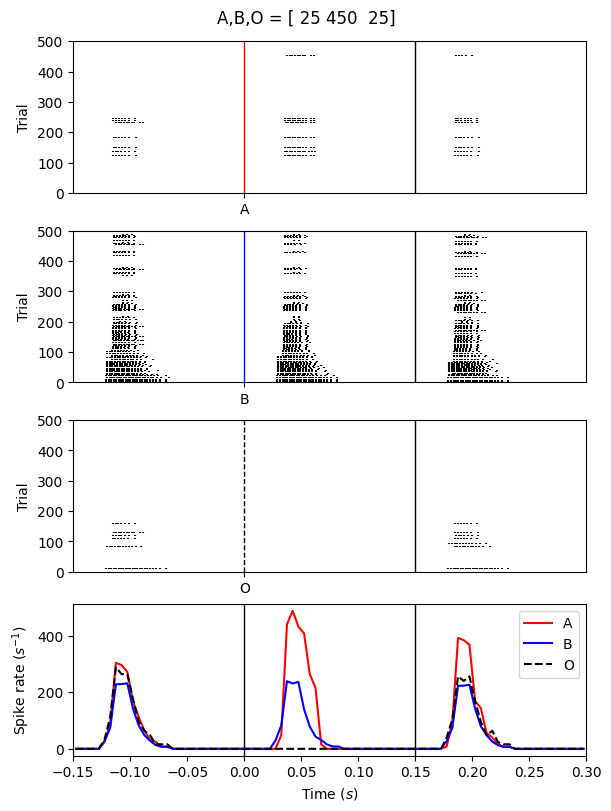

In [62]:
fig, axs = plt.subplots(4, figsize=(6,8), layout='constrained')
plt.suptitle(f'A,B,O = {occurrences}')
plot_trial_raster(axs, trains)

for label, ax in zip('ABO', axs):
    ax.set_xticks([0], [label])
    ax.set_ylim(0, n_trials)

plot_rates(axs[-1], trains, bins=90)